<a href="https://colab.research.google.com/github/joony0512/practical_statistics_for_Data_Scientists/blob/main/ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
feed =pd.read_csv('feed.csv')
feed

,Feed1,Feed2,Feed3,Feed4
0,60.8,68.7,69.6,61.9
1,67.0,67.7,77.1,64.2
2,65.0,75.0,75.2,63.1
3,68.6,73.3,71.5,66.7
4,61.7,71.8,NaN,60.3


In [5]:
birthwt = pd.read_csv('birthwt.csv')
birthwt

,low,age,lwt,race,smoke,ptl,ht,ui,ftv,bwt
0,0,19,182,2,0,0,0,1,0,2523
1,0,33,155,3,0,0,0,0,3,2551
2,0,20,105,1,1,0,0,0,1,2557
3,0,21,108,1,1,0,0,1,2,2594
4,0,18,107,1,1,0,0,1,0,2600
...,...,...,...,...,...,...,...,...,...,...
184,1,28,95,1,1,0,0,0,2,2466
185,1,14,100,3,0,0,0,0,2,2495
186,1,23,94,3,1,0,0,0,0,2495
187,1,17,142,2,0,0,1,0,0,2495


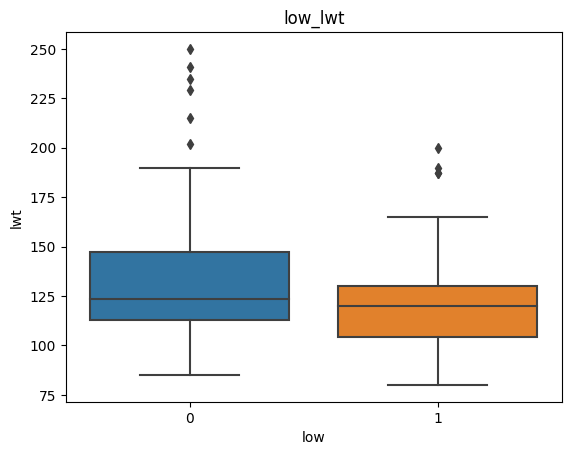

In [6]:
#1-1 미숙아여부(low) - 엄마의 몸무게(lwt)
fig, ax = plt.subplots()
low_lwt = sns.boxplot(x=birthwt['low'], y = birthwt['lwt'])
plt.title('low_lwt')
plt.show()

In [28]:
#1-2. 미숙아 여부에 따른 엄마 몸무게 평균차이에 대한 95% 신뢰구간을 계산하여라. 
from scipy import stats
from itertools import permutations
low_0_lwt =birthwt[birthwt['low']==0]['lwt']
low_1_lwt =birthwt[birthwt['low']==1]['lwt']


mean1, std1, n1 = low_0_lwt.mean(), low_0_lwt.std(), len(low_0_lwt)
mean2, std2, n2 = low_1_lwt.mean(), low_1_lwt.std(), len(low_1_lwt)

t_stat, p_value = stats.ttest_ind_from_stats(mean1, std1, n1, mean2, std2, n2)

ci_low, ci_high = stats.t.interval(alpha=0.95, df=n1+n2-2, loc=mean1-mean2, scale=np.sqrt((std1**2+std2**2)/n1))

print("두 집단의 평균 차이는", round(mean1-mean2, 2), "입니다.")
print("t-test 결과 p-value는", round(p_value, 4), "입니다.")
print("95% 신뢰 구간은 [", round(ci_low, 2), ",", round(ci_high, 2), "] 입니다.")


두 집단의 평균 차이는 11.16 입니다.
t-test 결과 p-value는 0.0196 입니다.
95% 신뢰 구간은 [ 4.01 , 18.32 ] 입니다.


<ipython-input-28-a61528eaa2f6>:13: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  ci_low, ci_high = stats.t.interval(alpha=0.95, df=n1+n2-2, loc=mean1-mean2, scale=np.sqrt((std1**2+std2**2)/n1))


In [29]:
#1-3. 미숙아 여부에 따른 엄마 몸무게 평균차이에 대한 95% 부트스르랩 신뢰구간을 계산하여라.
def bootstrap_diff_confidence_interval(x, y, n_iter=1000, alpha=0.05):
    """
    x, y: 두 개의 샘플 데이터
    n_iter: 부트스트랩 샘플링 횟수
    alpha: 유의 수준
    """
    # 두 샘플의 평균 차이 계산
    obs_diff = np.mean(x) - np.mean(y)
    
    # 전체 데이터를 합쳐서 부트스트랩 샘플링에 사용
    data = np.concatenate((x, y))
    
    # 부트스트랩 샘플링 및 평균 차이 계산
    diffs = []
    for i in range(n_iter):
        sample_x = np.random.choice(data, size=len(x), replace=True)
        sample_y = np.random.choice(data, size=len(y), replace=True)
        diff = np.mean(sample_x) - np.mean(sample_y)
        diffs.append(diff)
    
    # 신뢰구간 계산
    lower = np.percentile(diffs, (alpha / 2) * 100)
    upper = np.percentile(diffs, (1 - alpha / 2) * 100)
    
    # 신뢰구간이 0을 포함하는지 여부에 따라 p-value 계산
    p_value = 2 * min(np.mean(np.array(diffs) <= 0), np.mean(np.array(diffs) > 0))

    
    return obs_diff, p_value, (lower, upper)


b_low_lwt_test =bootstrap_diff_confidence_interval(low_0_lwt,low_1_lwt)
b_low_lwt_test

(11.164406779661022, 0.988, (-9.156121251629736, 8.839771838331158))

In [30]:
#1-4. 미숙아 여부에 따른 엄마 몸무게 평균차이에 대한 통계적 유의성 검정을 수행하여라. 
from scipy.stats import t

def welch_ttest(x, y, alpha=0.05):
    """
    Welch's t-test를 수행하고, p-value와 유의수준 alpha에서의 신뢰구간을 반환합니다.
    """
    # 각 샘플의 평균, 표준편차, 샘플 크기 계산
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_std = np.std(x, ddof=1)
    y_std = np.std(y, ddof=1)
    x_size = len(x)
    y_size = len(y)
    
    # t-value 계산
    t_value = (x_mean - y_mean) / np.sqrt((x_std ** 2 / x_size) + (y_std ** 2 / y_size))
    
    # 자유도 계산
    df = ((x_std ** 2 / x_size) + (y_std ** 2 / y_size)) ** 2 / ((x_std ** 2 / x_size) ** 2 / (x_size - 1) + (y_std ** 2 / y_size) ** 2 / (y_size - 1))
    
    # p-value 계산
    p_value = (1 - t.cdf(np.abs(t_value), df)) * 2
    
    # 신뢰구간 계산
    se = np.sqrt((x_std ** 2 / x_size) + (y_std ** 2 / y_size))
    margin_error = t.ppf(1 - alpha / 2, df) * se
    lower = (x_mean - y_mean) - margin_error
    upper = (x_mean - y_mean) + margin_error
    
    return t_value, p_value, (lower, upper)

t_test =welch_ttest(low_0_lwt,low_1_lwt)
t_test

(2.51553416666028,
 0.013080334179202735,
 (2.3855195659568125, 19.94329399336523))

In [41]:
#1-5. 1-3에서 수행한 검정을 순열검정으로 다시 수행한 후 이 결과를 1-3의 결과와 비교하여라.
import numpy as np
from itertools import permutations, islice

low_0_lwt =birthwt[birthwt['low']==0]['lwt'].tolist()
low_1_lwt =birthwt[birthwt['low']==1]['lwt'].tolist()


def permutation_test(x, y, n_perm=1000, alpha=0.05):
    """
    x, y: 두 개의 샘플 데이터
    n_perm: 순열 생성 횟수
    alpha: 유의 수준
    """
    # 두 샘플의 평균 차이 계산
    obs_diff = np.mean(x) - np.mean(y)
    
    # 두 샘플을 합쳐 전체 데이터를 만듦
    data = np.concatenate((x, y))
    
    # 순열 생성 및 검정
    perm_diffs = []
    for i in range(n_perm):
        perm_data = np.random.permutation(data)
        perm_x = list(islice(perm_data, len(x)))
        perm_y = list(islice(perm_data, len(y)))
        perm_diffs.append(np.mean(perm_x) - np.mean(perm_y))

    # p-value 계산
    p_value = np.round(np.sum(np.abs(perm_diffs) >= np.abs(obs_diff)) / n_perm, 5)

    
    # 신뢰구간 계산
    lower = np.percentile(perm_diffs, (alpha / 2) * 100)
    upper = np.percentile(perm_diffs, (1 - alpha / 2) * 100)
    
    return obs_diff, p_value, (lower, upper)


low_lwt_test = permutation_test(low_0_lwt, low_1_lwt)
print(f"{low_lwt_test[0]:.5f}, {low_lwt_test[1]:.5f}, ({low_lwt_test[2][0]:.5f}, {low_lwt_test[2][1]:.5f})")


11.16441, 0.00000, (-5.39397, 5.44160)


In [49]:
#2교재 표 3-2는 2*2 분할표 자료이다. 
# 이 자료를 가지고 전환 결과와 가격 두 변수 간 연관성이 있는지 여부를 검정하기 위한 카이제곱 검정을 수행하여라. 
# 또한 Fisher의 정확검정도 함께 수행하고 두 결과를 비교하여라. 

import numpy as np
from scipy.stats import chi2_contingency

observed = np.array([[200, 23539], [182, 22406]])
chi2, p_value, dof, expected = chi2_contingency(observed)

print(f"카이제곱 검정 결과: chi2 = {chi2:.4f}, p-value = {p_value:.4f}")

카이제곱 검정 결과: chi2 = 0.1489, p-value = 0.6996


In [34]:
import scipy.stats as stats

# contingency table 생성
cont_table = [[200, 23539], [182, 22406]]

# Fisher's exact test 수행
odds_ratio, pvalue = stats.fisher_exact(cont_table)

print("Odds ratio:", odds_ratio)
print("p-value:", pvalue)


Odds ratio: 1.0460078177483334
p-value: 0.6811282492348564


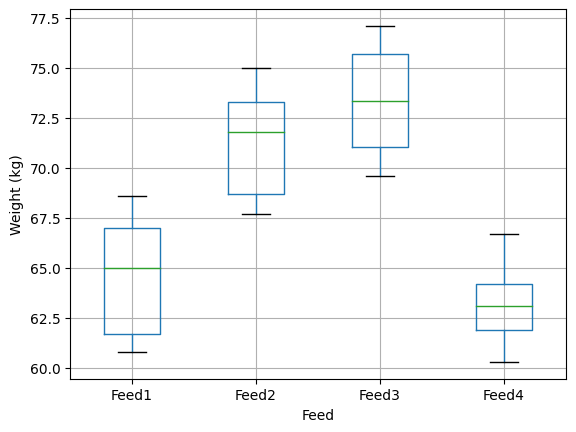

In [45]:
#3'Feed' 데이터를 사용하여 아래의 내용을 검증하고 적합한 가설 검정을 수행하여라. 
#돼지 19마리가 무작위로 4개의 실험 그룹에 할당되었고, 각 그룹은 서로 다른 식단을 제공받는다. 
#데이터는 돼지의 체중이며, 단위는 킬로그램(kg)이다. 그룹별로 다른 식단을 먹고 자란 돼지의 체중이 4종류의 식단에서 모두 동일한지 여부를 조사하고자 한다. 
#(필요한 경우, 데이터는 분석을 위해 적절하게 처리될 수 있다.)
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('feed.csv')

df.boxplot()
plt.xlabel('Feed')
plt.ylabel('Weight (kg)')
plt.show()


In [46]:
# 이상치(outlier) 제거
df = df.dropna()

# 각 그룹별로 데이터 추출
feed1 = df['Feed1'].tolist()
feed2 = df['Feed2'].tolist()
feed3 = df['Feed3'].tolist()
feed4 = df['Feed4'].tolist()

# ANOVA 검정 수행
from scipy.stats import f_oneway

F_statistic, p_value = f_oneway(feed1, feed2, feed3, feed4)
print('F statistic:', F_statistic)
print('p-value:', p_value)


F statistic: 8.212901870140781
p-value: 0.003068882135049821


In [47]:
from scipy.stats import f_oneway

# 각 그룹의 체중 데이터
group1 = [60.8, 67.0, 65.0, 68.6, 61.7]
group2 = [68.7, 67.7, 75.0, 73.3, 71.8]
group3 = [69.6, 77.1, 75.2, 71.5]
group4 = [61.9, 64.2, 63.1, 66.7, 60.3]

# 일원 분산 분석 수행
f_statistic, p_value = f_oneway(group1, group2, group3, group4)

# 결과 출력
print("F-statistic: {:.2f}".format(f_statistic))
print("p-value: {:.4f}".format(p_value))


F-statistic: 12.04
p-value: 0.0003
